## Winner Pokemon Combat Prediction

This is my notebook I used to explore Pokemon Combat data, and use this as my milestone to learn machine learning.
In this notebook, I do several activities i.e. Data Preprocessing, Exploration Data Analysis (EDA), and Modeling.
Here are the outline of this notebook.

** 1. Data Preprocessing**

** 2. Exploratory Data Analysis (EDA)**

** 3. Tree-Based Model**

** 3.a Classification Tree**

** 3.b Random Forest**


### 1. Data Preprocessing

In [1]:
# Library
library('ggplot2') #visualization
library('corrplot') #visualization
library("Hmisc") #correlation
library('rpart') #classification algorithm - Binary Tree
library('rpart.plot') #visualization tree
library('randomForest') #algorithm - Random Forest
library('MASS')

corrplot 0.84 loaded
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units


Attaching package: ‘rpart’

The following object is masked from ‘package:survival’:

    solder

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [2]:
# Read File
combat <- read.csv(file = "../input/combats.csv", header = TRUE)
pokemon <- read.csv(file = "../input/pokemon.csv", header = TRUE)
test <- read.csv(file = "../input/tests.csv", header = TRUE)

Look into the dataset.
See fields type and correlation to the goal which is predict which pokemon will win the battle.

In [3]:
str(combat)
str(pokemon)

'data.frame':	50000 obs. of  3 variables:
 $ First_pokemon : int  266 702 191 237 151 657 192 73 220 302 ...
 $ Second_pokemon: int  298 701 668 683 231 752 134 545 763 31 ...
 $ Winner        : int  298 701 668 683 151 657 134 545 763 31 ...
'data.frame':	800 obs. of  12 variables:
 $ X.        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Name      : Factor w/ 800 levels "","Abomasnow",..: 70 309 746 454 89 90 88 420 421 669 ...
 $ Type.1    : Factor w/ 18 levels "Bug","Dark","Dragon",..: 10 10 10 10 7 7 7 7 7 18 ...
 $ Type.2    : Factor w/ 19 levels "","Bug","Dark",..: 15 15 15 15 1 1 9 4 9 1 ...
 $ HP        : int  45 60 80 80 39 58 78 78 78 44 ...
 $ Attack    : int  49 62 82 100 52 64 84 130 104 48 ...
 $ Defense   : int  49 63 83 123 43 58 78 111 78 65 ...
 $ Sp..Atk   : int  65 80 100 122 60 80 109 130 159 50 ...
 $ Sp..Def   : int  65 80 100 120 50 65 85 85 115 64 ...
 $ Speed     : int  45 60 80 80 65 80 100 100 100 43 ...
 $ Generation: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Legendary : Fact

Looks like we have separated information here
The file combat only contains which pokemon were battling and the file pokemon contains all the statistic
in pokemon dataset.

We will combine these two information in one data.frame
which contains statistic infomation of first pokemon, the second pokemon and the winner

In [4]:
pokefight <- combat

pokefight$ID_1 <- (combat$First_pokemon)
pokefight$Type1_1 <- pokemon$Type.1[combat$First_pokemon]
pokefight$Type2_1 <- pokemon$Type.2[combat$First_pokemon]
pokefight$HP_1 <- pokemon$HP[combat$First_pokemon]
pokefight$Attack_1 <- pokemon$Attack[combat$First_pokemon]
pokefight$Defense_1 <- pokemon$Defense[combat$First_pokemon]
pokefight$Sp..Atk_1 <- pokemon$Sp..Atk[combat$First_pokemon]
pokefight$Sp..Def_1 <- pokemon$Sp..Def[combat$First_pokemon]
pokefight$Speed_1 <- pokemon$Speed[combat$First_pokemon]
pokefight$Generation_1 <- pokemon$Generation[combat$First_pokemon]
pokefight$Legendary_1 <- pokemon$Legendary[combat$First_pokemon]

pokefight$ID_2 <- (combat$Second_pokemon)
pokefight$Type1_2 <- pokemon$Type.1[combat$Second_pokemon]
pokefight$Type2_2 <- pokemon$Type.2[combat$Second_pokemon]
pokefight$HP_2 <- pokemon$HP[combat$Second_pokemon]
pokefight$Attack_2 <- pokemon$Attack[combat$Second_pokemon]
pokefight$Defense_2 <- pokemon$Defense[combat$Second_pokemon]
pokefight$Sp..Atk_2 <- pokemon$Sp..Atk[combat$Second_pokemon]
pokefight$Sp..Def_2 <- pokemon$Sp..Def[combat$Second_pokemon]
pokefight$Speed_2 <- pokemon$Speed[combat$Second_pokemon]
pokefight$Generation_2 <- pokemon$Generation[combat$Second_pokemon]
pokefight$Legendary_2 <- pokemon$Legendary[combat$Second_pokemon]
pokefight$Result[pokefight$Winner == pokefight$First_pokemon] <- 'Win'
pokefight$Result[pokefight$Winner == pokefight$Second_pokemon] <- 'Loss'

pokefight$Result <- as.factor(pokefight$Result)
pokefight$Generation_1 <- as.factor(pokefight$Generation_1)
pokefight$Generation_2 <- as.factor(pokefight$Generation_2)

In [5]:
# Let's see structure of our data now
#str(pokefight)

Here we go we have all the information in one dataframe.

### 2. Data Exploration Analysis (EDA)

How fast pokemon in every type?

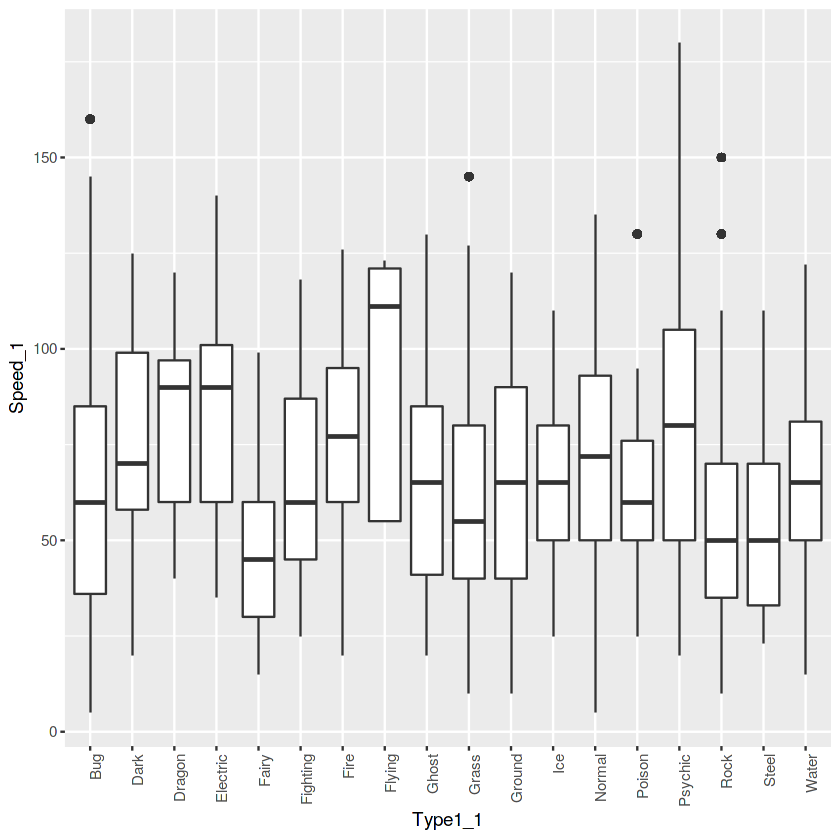

In [6]:
ggplot(pokefight, aes(x=Type1_1  , y= Speed_1)) + geom_boxplot(position = 'dodge') + theme(axis.text.x = element_text(angle = 90, hjust = 1))

Does Legendary pokemons are faster than non-Legendary pokemons?

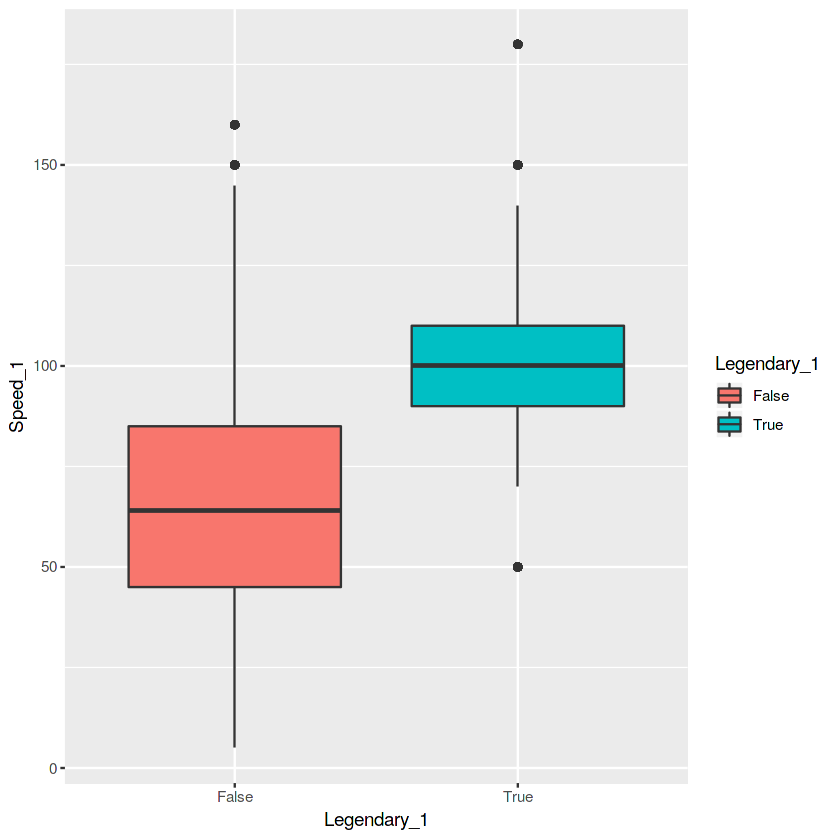

In [7]:
ggplot(pokefight, aes(Legendary_1, Speed_1,  fill = Legendary_1)) + geom_boxplot(position = 'dodge') 

How speed will affect the result of combat?

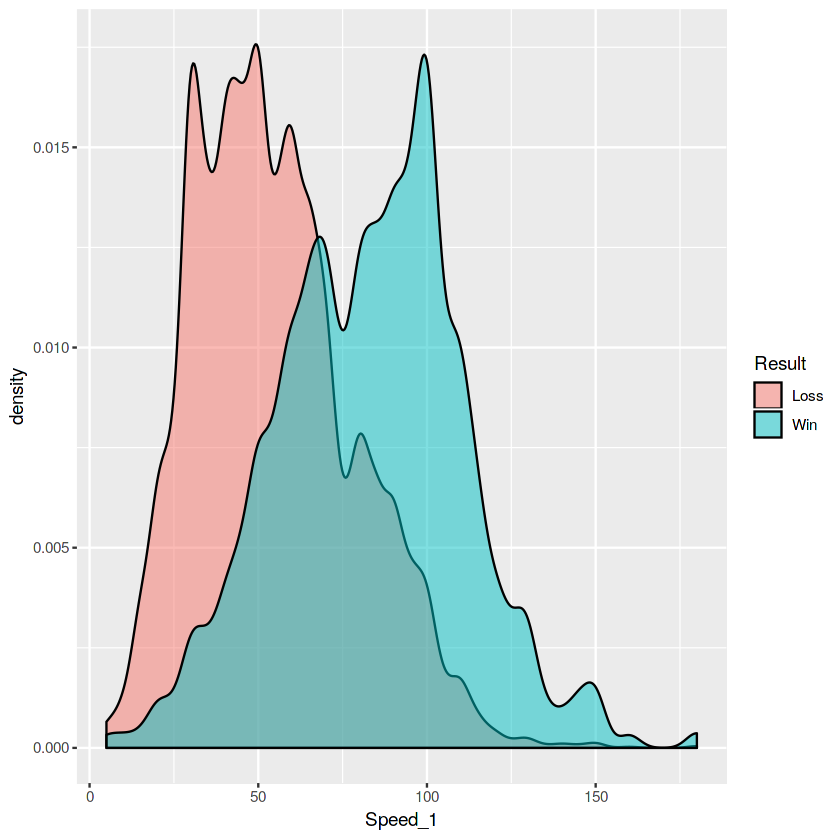

In [8]:
ggplot(pokefight, aes(Speed_1, fill = Result)) + geom_density(alpha = 0.5)

We can see the majority of winner pokemons are faster than majority of loser pokemon.
In addition, we can see in more intuitive feature which is the difference in speed between pokemon on every fight. Does speed-difference could help us to distinguish winner and loser?

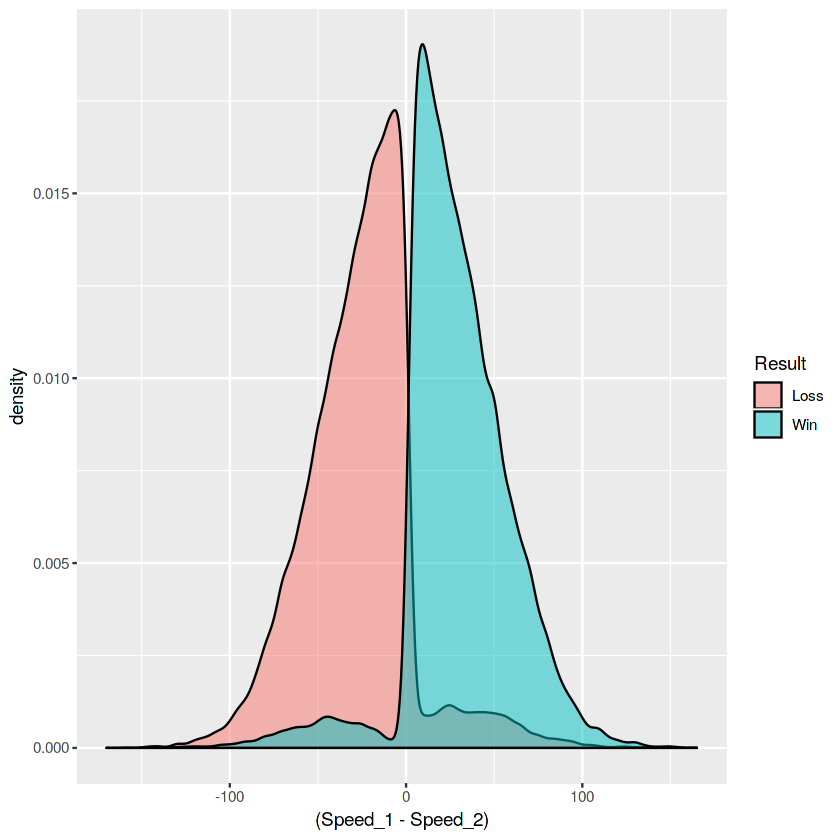

In [9]:
ggplot(pokefight, aes((Speed_1-Speed_2), fill = Result)) + geom_density(alpha = 0.5)

Turns out speed-difference has clearer treshold to distinguish between winner and loser.


Let's first generate feature : the difference in Health Point (HP), Attack, Defense, Sp..Atk, Sp..Def, and then see the correlations of each variable to combat's result.

In [10]:
# Create 'difference' features
pokefight$diff_HP = pokefight$HP_1 - pokefight$HP_2
pokefight$diff_Attack = pokefight$Attack_1 - pokefight$Attack_2
pokefight$diff_Defense = pokefight$Defense_1 - pokefight$Defense_2
pokefight$diff_Sp..Atk = pokefight$Sp..Atk_1 - pokefight$Sp..Atk_2
pokefight$diff_Sp..Def = pokefight$Sp..Def_1 - pokefight$Sp..Def_2
pokefight$diff_Speed = pokefight$Speed_1 - pokefight$Speed_2

# Create binary variable of Result ('Win/Lose' to numeric variable '1/0')
pokefight$binaryResult[pokefight$Result == "Win"] <- 1
pokefight$binaryResult[pokefight$Result == "Loss"] <- 0

#summary(pokefight)

In [11]:
# Create dataframe which only consist of numeric features
numeric_metrics <- pokefight[ ,c('binaryResult', 
                                'diff_HP', 'diff_Attack', 'diff_Defense', 
                                'diff_Sp..Atk', 'diff_Sp..Def', 'diff_Speed',
                                'HP_1', 'Attack_1', 'Defense_1', 'Sp..Atk_1', 'Sp..Def_1', 'Speed_1')]

# Create correlation matrix which consists of numeric features
cor_matrix <- cor(numeric_metrics)

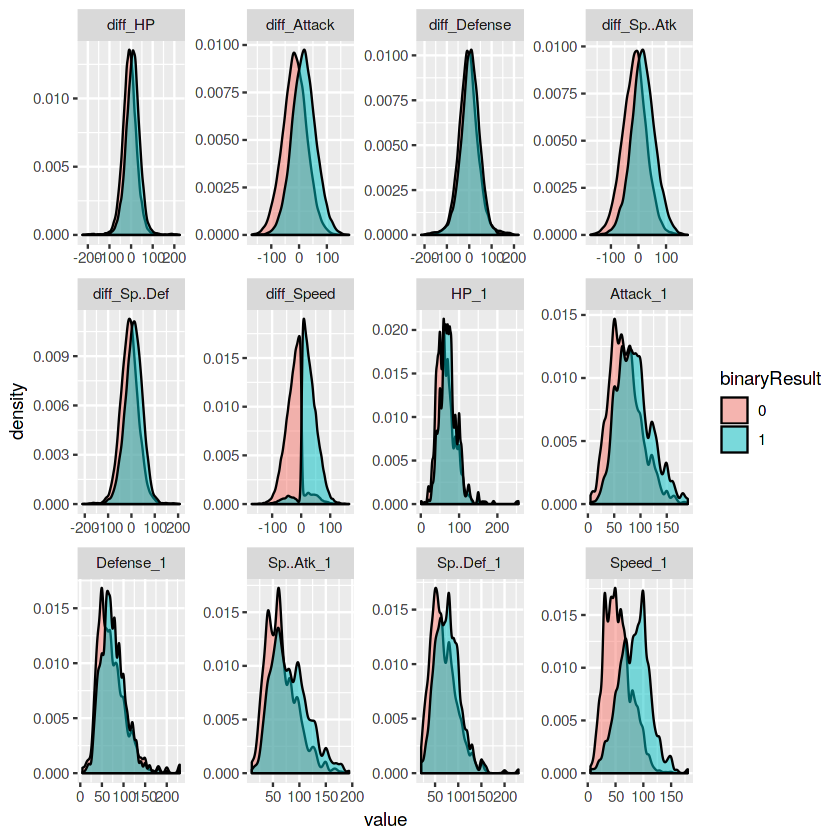

In [12]:
# See multiple density plot

# Create long table using 'melt'
mtxlong <- reshape2::melt(numeric_metrics, id.vars = "binaryResult")

# Generate multiple density chart
ggplot(mtxlong, aes(value, fill = factor(binaryResult))) + #create a canvas 
        facet_wrap(~variable, scales = 'free', strip.position = 'top') + #create sequence of panels
        geom_density(alpha = '0.5') + #create density plot 
        labs(fill = 'binaryResult') #rename the legend

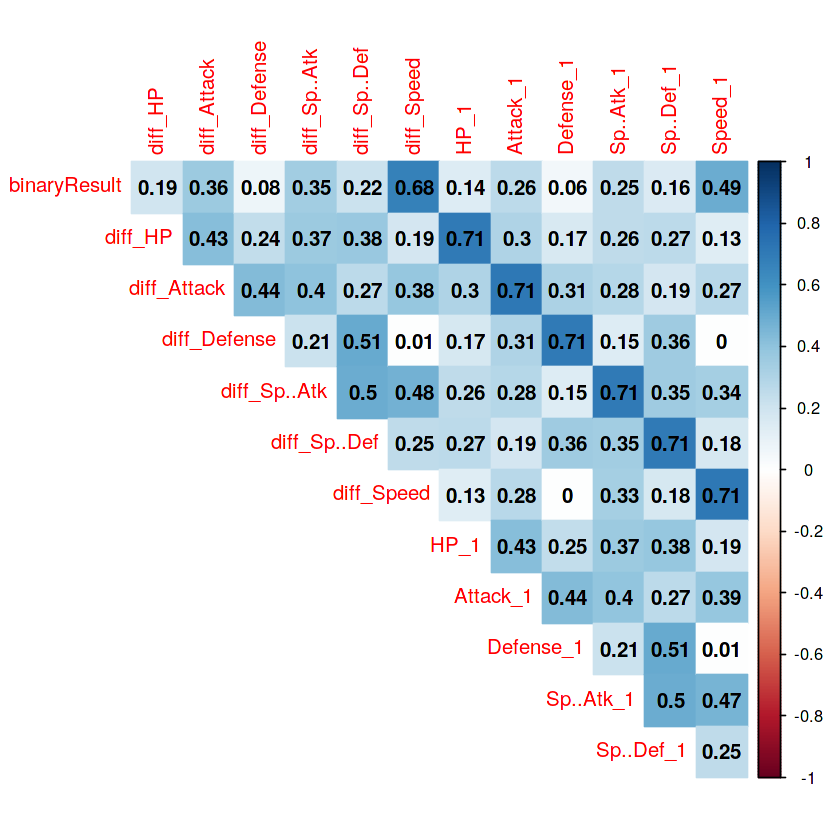

In [13]:
# Correlation Plot with correlation coefficient
corrplot(cor_matrix, 
         method = "color", 
         addCoef.col = "black", #shows correlation coef
         type = 'upper', #only shows upper plot
         diag = FALSE #hide the diagonal
        )

Based on EDA we've done, we see that the two features which could distinguish between winner and loser are Speed_1 and diff_Speed.
We can continue to create classification to predict which pokemon would win the combat.

### 3. Tree-Based Model
I would use two type of classification model, Classification Tree and Random Forest. What is the difference between these two models? Both are tree-based model, the essential difference is Clasification Tree only has one tree to classify and Random Forest has multiple trees to classify with randomly picked variable in each tree.

#### 3.a Classification Tree

First before creating model, lets prepare the train and test dataset.
We will make two portion from this 50000 row. 80% for the training data and the rest is test data.


In [14]:
set.seed(117)
random <- sample(1:50000, size = 40000)
train <- pokefight[random, ]
test <- pokefight[-random, ]

# Get the test_label and the test data
test_label <- test[,26] # Column 26 is target
test_data <- test[,-26]
test_data$Result <- '0'

In [15]:
binary_tree_1 <- rpart(Result ~   diff_Speed + Speed_1, data = train, method = 'class' )

In [16]:
# Predict winner using binary tree 1
result_1 <- predict(binary_tree_1, test_data, type = 'class')
table(result_1, test_label)

        test_label
result_1 Loss  Win
    Loss 4960  204
    Win   361 4475

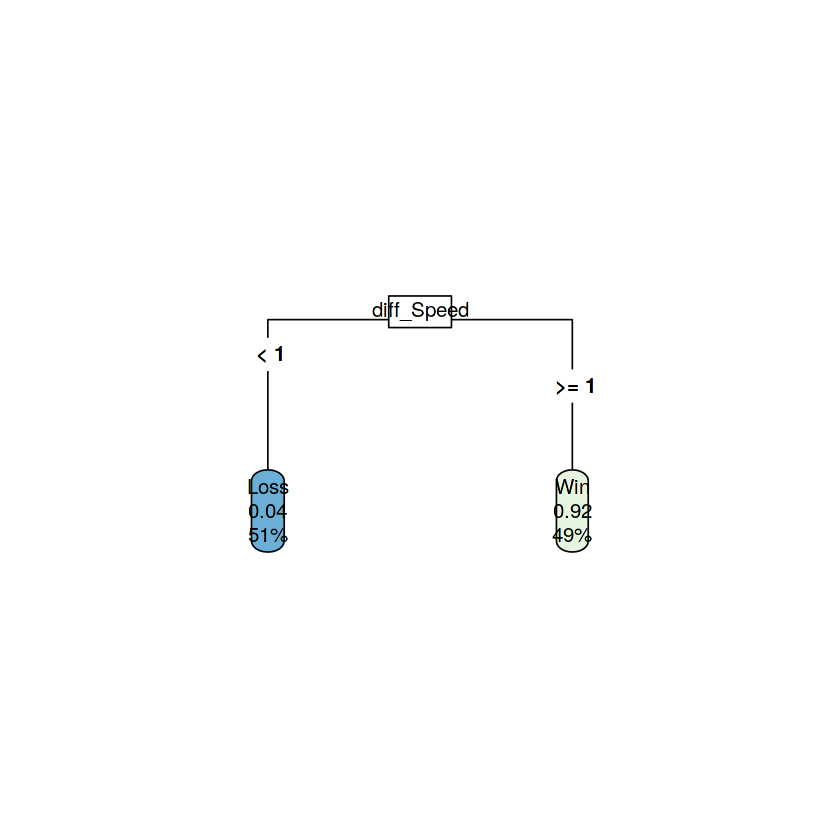

In [17]:
rpart.plot(binary_tree_1, type = 5)

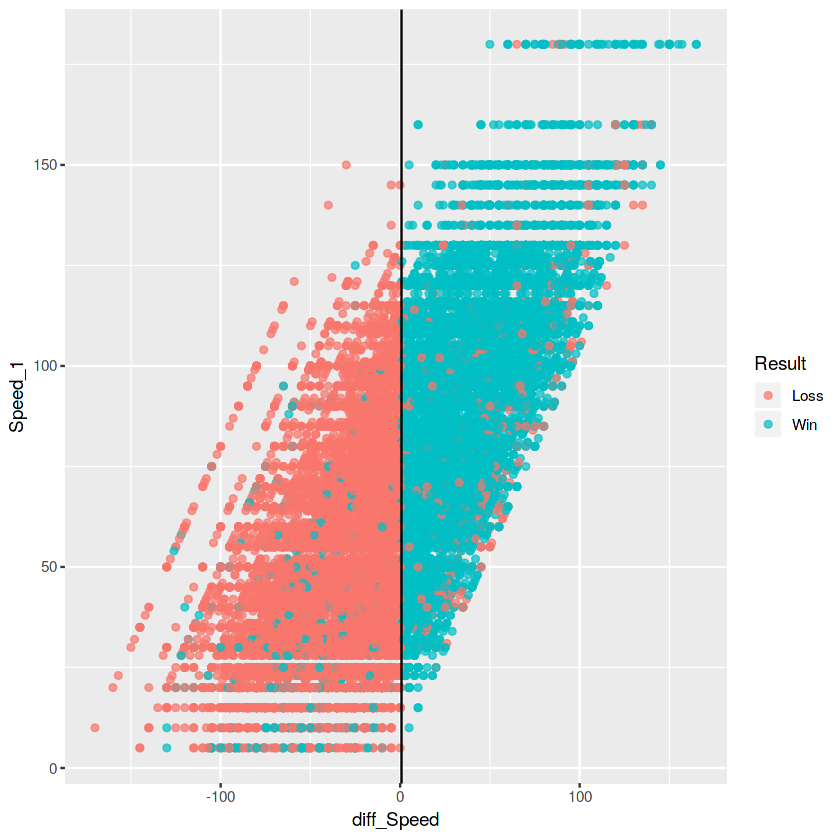

In [18]:
ggplot(pokefight, aes(y = Speed_1 , x = diff_Speed, color = Result)) + geom_point(alpha = "0.7") + geom_vline(xintercept = 1)

We got accuracy = 94,35% (quite high!), and see the tree only have one node (really simple tree!). The tree is simple because using these two feature we already could the majority of winner and loser. Let's continue with Random Forest so we could include others features.

#### 3.a Random Forest

In [19]:
# Create Dataframe which has more than numeric feature
all_metrics <- pokefight[ ,c('Result',
                                'diff_HP', 'diff_Attack', 'diff_Defense', 
                                'diff_Sp..Atk', 'diff_Sp..Def', 'diff_Speed',
                                'HP_1', 'Attack_1', 'Defense_1', 'Sp..Atk_1',
                                'Sp..Def_1', 'Speed_1', 'Type1_1', 'Type2_1',
                                'Generation_1', 'Legendary_1',
                                'HP_2', 'Attack_2', 'Defense_2', 'Sp..Atk_2',
                                'Sp..Def_2', 'Speed_2', 'Type1_2', 'Type2_2',
                                'Generation_2', 'Legendary_2'
                            )]
# Now we have include 26 features + 1 taarget in one dataframe

In [20]:
# Create Train and Test Dataset
set.seed(117)
random <- sample(1:50000, size = 40000)
train <- all_metrics[random, ]
test <- all_metrics[-random, ]

# Get the test_label and the test data
test_label <- test[,1] # Column 1 is target
test_data <- test[,-1]
test_data$Result <- '0'

Random Forest is actually a tree-based model, but it has additional technic which is decorrelate the several trees which are generated by the different bootstrapped samples from training Data. And then it simply reduce the Variance in the Trees by averaging them (or choosing majority for classification). So, instead of using one tree to decide the prediction, it considers many trees to generate prediction.

In [21]:
rf_tree <- randomForest(Result ~. , data = train, type = 'classification', ntree = 500 )
rf_tree


Call:
 randomForest(formula = Result ~ ., data = train, type = "classification",      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 3.72%
Confusion matrix:
      Loss   Win class.error
Loss 20209   869  0.04122782
Win    617 18305  0.03260755

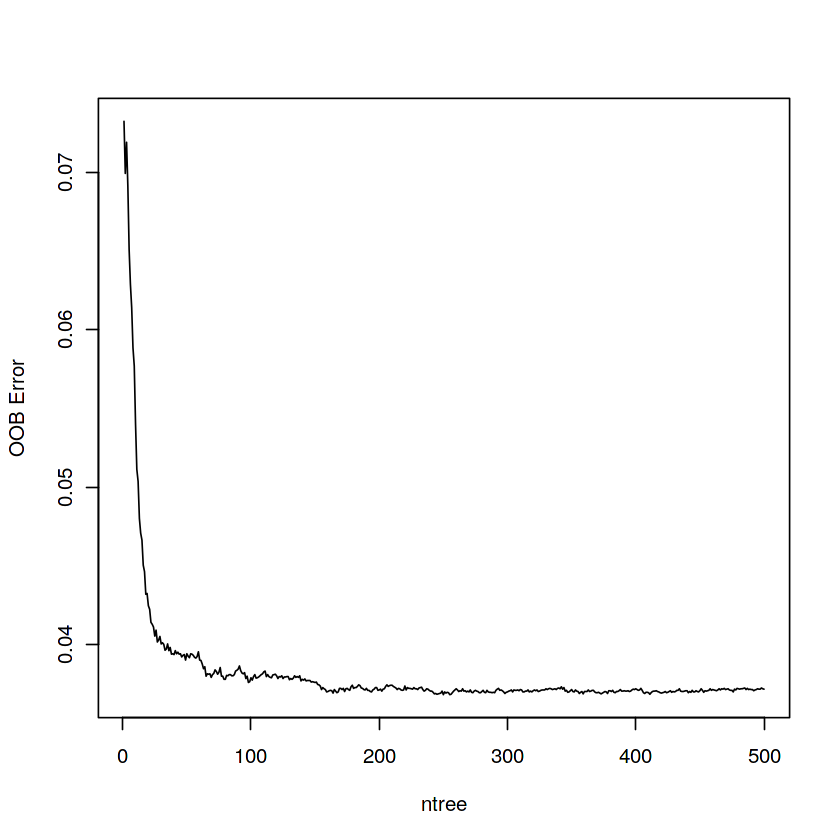

In [22]:
plot(rf_tree$err.rate[,1], ylab= "OOB Error", xlab= 'ntree', type = 'l')

This plot shows the Error and the Number of Trees. We can easily notice that how the Error is dropping as we keep on adding more and more trees.

In [23]:
# Predict the result using Random Forest Model
pred <- predict(rf_tree, test_data)
table(pred, test_label)

      test_label
pred   Loss  Win
  Loss 5106  129
  Win   215 4550

We got accuracy 96,56%! (2,03% difference). The random forest model has higher accuracy, even with default parameter.
In random forest there is one parameter : mtry which means number of features picked randomly to create tree.
Let's see which the optimal mtry to get the lowest error.

In [24]:
oob.err=double(20)
for(mtry in 1:20){
  fit=randomForest(Result~.,data=train,mtry=mtry,ntree=50)
  oob.err[mtry]=fit$err.rate[50]
  cat(mtry," ")
}
oob.err

1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  

[1] 0.065525 0.047675 0.045400 0.040750 0.036800 0.036200 0.034725 0.032525
 [9] 0.032225 0.031225 0.030650 0.029825 0.029625 0.029350 0.029300 0.028525
[17] 0.028450 0.028825 0.028375 0.027775

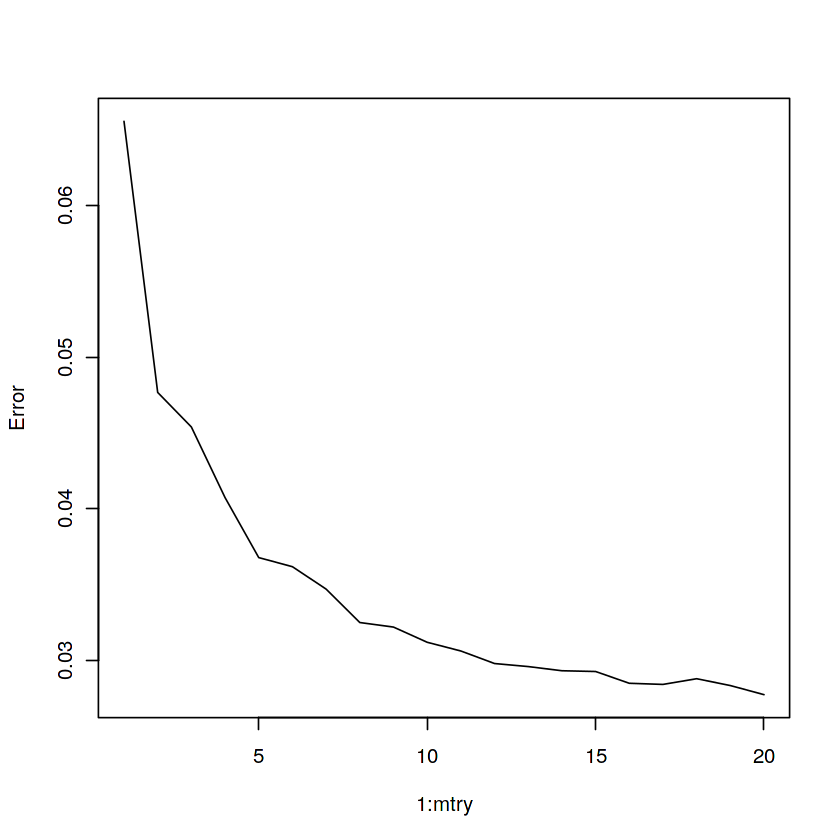

In [25]:
plot(oob.err, ylab= "Error", xlab= '1:mtry', type = 'l')

This plot shows the Error and the mtry. We can easily notice relation between "mtry" and error. Noticeably, mtry = 20 has lowest error. So we could combine "mtry" and "ntree" to get the lowest error (mtry = 20 and ntree = 500)

In [26]:
# Random Forest Model Final
rf_tree_final <- randomForest(Result ~. , data = train, type = 'classification', mtry = 20, ntree = 500 )
rf_tree_final
pred <- predict(rf_tree_final, test_data)
table(pred, test_label)


Call:
 randomForest(formula = Result ~ ., data = train, type = "classification",      mtry = 20, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 20

        OOB estimate of  error rate: 2.69%
Confusion matrix:
      Loss   Win class.error
Loss 20499   579  0.02746940
Win    497 18425  0.02626572

      test_label
pred   Loss  Win
  Loss 5175  112
  Win   146 4567

Got accuracy 97,38%! (0.82% increment!) We can could conclude that we successfully set two parameter ("mtry" and "ntree") to increase accuracy.


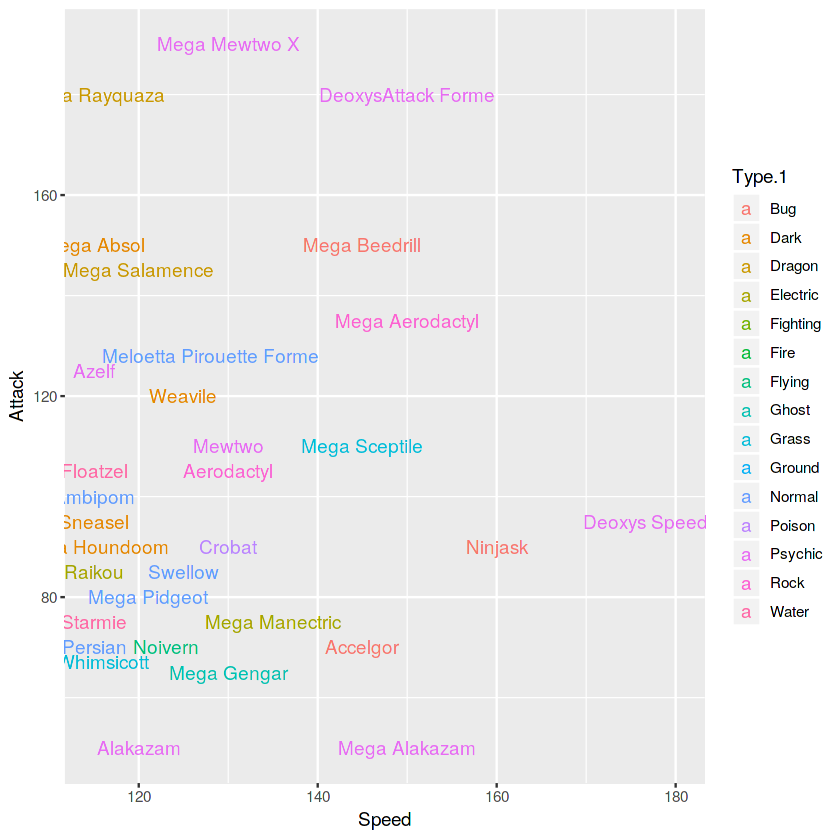

In [27]:
# Get Pokemon which has higher Speed rather than 95% population
ggplot(pokemon[pokemon$Speed>=quantile(pokemon$Speed,0.95),c("Name","Speed","Attack",'Type.1')], aes(x=Speed, y=Attack, col= Type.1, label = Name)) + geom_text(check_overlap = TRUE)

### Conclusion
1. We successfully create prediction model using Random Forest method with accuracy 97,37%!
2. Random Forest model has higher accuracy (3.03% difference) rather than Classification Tree which only has one node.
3. difference Speed and Speed of first pokemon are two most important features.

Considering Speed is important feature in winning probability, you could look up to scatter plot before choosing Pokemon for combat.